In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#!pip install fastai
#!pip install opencv
#!pip install opencv-python



from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import cv2 as cv
from IPython.display import Image

from fastai.vision import *
from fastai import *
from fastai.widgets import *

In [47]:
data = ImageDataBunch.from_folder(
    './images',         # path for the dataset and model 
    valid_pct=0.2,       # train / val split
    ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
    size=100,            # image size
    bs=25       # batch size
)

In [49]:
data.show_batch(rows=3, figsize=(100, 100))

In [50]:
data.normalize(imagenet_stats)                         # normalization

ImageDataBunch;

Train: LabelList (791 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
H,H,H,H,H
Path: images;

Valid: LabelList (197 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
H,S,H,H,B
Path: images;

Test: None

In [51]:
print(data.c, data.classes)

3 ['B', 'H', 'S']


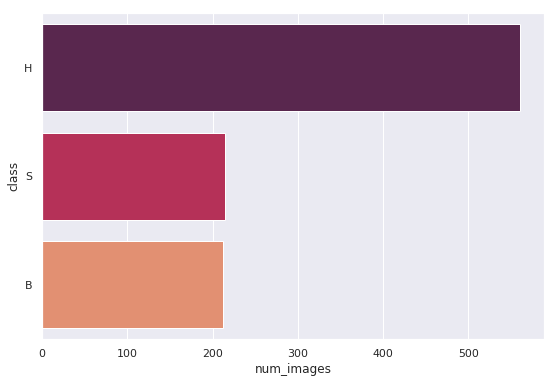

In [52]:
# count the number of images in each class folder
num_images = [len(Path(path_images/class_).ls()) for class_ in data.classes]
classes = pd.DataFrame({'class':data.classes, 
                                 'num_images':num_images}).sort_values('num_images', ascending=False)
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot('num_images','class', data=classes, palette='rocket')

In [53]:
model = cnn_learner(data, models.resnet34, metrics = error_rate)

In [54]:
model

Learner(data=ImageDataBunch;

Train: LabelList (791 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
H,H,H,H,H
Path: images;

Valid: LabelList (197 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
H,S,H,H,B
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (

In [55]:
model.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.380408,1.241008,0.573604,01:16
1,1.307677,1.194663,0.492386,01:16


In [56]:
model.save('stage-1', return_path=True)

PosixPath('images/models/stage-1.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


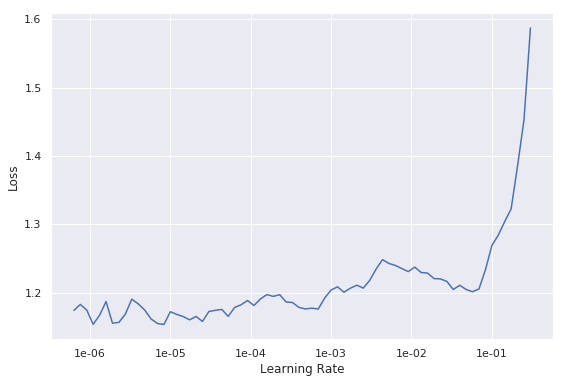

In [57]:
# unfreeze before lr_finder!!! 
# to find the best learning rates for retrain of the whole model
model.unfreeze() 
model.lr_find()
model.recorder.plot()

In [58]:
model.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
model.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,1.154521,1.161796,0.517766,01:56
1,1.171249,1.150190,0.502538,01:55


In [59]:
interp = ClassificationInterpretation.from_learner(model)

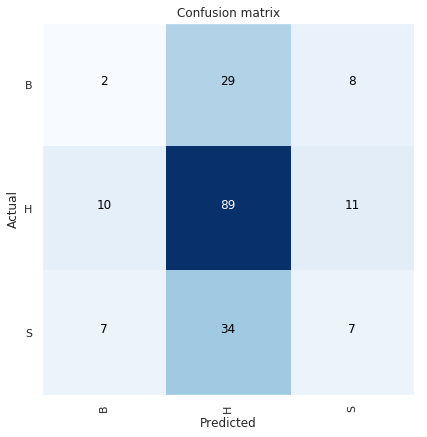

In [60]:
interp.plot_confusion_matrix(); 